# INFO-6154-Assignment 1


##1. Installing requirements packages

In [1]:
!pip install optuna tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 25.5 MB/s eta 0:00:00


##2. Importing necessary libraries

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.samplers import TPESampler, RandomSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

##3. Setting GPU

In [20]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Check for GPU
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0


##4. Building the GRU Architecture

In [21]:
def create_gru_model(input_shape, hidden_units, num_layers, dropout_rate, learning_rate):
    model = Sequential()

    # First GRU layer
    if num_layers == 1:
        model.add(GRU(hidden_units, input_shape=input_shape, return_sequences=False))
    else:
        model.add(GRU(hidden_units, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))

        # Additional GRU layers
        for i in range(1, num_layers - 1):
            model.add(GRU(hidden_units, return_sequences=True))
            model.add(Dropout(dropout_rate))

        # Last GRU layer
        model.add(GRU(hidden_units, return_sequences=False))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

##5. Creating the model

In [35]:
def prepare_data(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def objective(trial, X_train, y_train, X_val, y_val, sequence_length):
    # Hyperparameters to tune
    hidden_units = trial.suggest_categorical('hidden_units', [64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128])

    # Create model
    model = create_gru_model(
        input_shape=(sequence_length, 1),
        hidden_units=hidden_units,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Get best validation loss
    best_val_loss = min(history.history['val_loss'])

    # Clear session to free memory
    tf.keras.backend.clear_session()

    return best_val_loss

##6. Evaluating Model

In [36]:
def evaluate_model(model, X_test, y_test, scaler):
    # Make predictions
    predictions = model.predict(X_test, verbose=0)

    # Inverse transform predictions and actual values
    predictions_actual = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, predictions_actual)
    mae = mean_absolute_error(y_test_actual, predictions_actual)
    rmse = np.sqrt(mse)

    return mse, mae, rmse, predictions_actual, y_test_actual

##7. Setting Optimization

In [37]:
def run_optuna_optimization(sampler, sampler_name, X_train, y_train, X_val, y_val, sequence_length, n_trials=10):
    print(f"Running Optuna with {sampler_name} Sampler - {n_trials} trials")

    study = optuna.create_study(
        direction='minimize',
        sampler=sampler
    )

    # Add progress bar for Optuna trials
    with tqdm(total=n_trials, desc=f"Optuna {sampler_name}") as pbar:
        def callback(study, trial):
            pbar.update(1)
            pbar.set_postfix({'Best Value': f'{study.best_value:.4f}'})

        study.optimize(
            lambda trial: objective(trial, X_train, y_train, X_val, y_val, sequence_length),
            n_trials=n_trials,
            callbacks=[callback]
        )

    print(f"Best trial for {sampler_name}:")
    trial = study.best_trial
    print(f"Value (Validation Loss): {trial.value:.4f}")
    print("Best Hyperparameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study.best_params, trial.value

##8. Loading and Preparing data

In [38]:
print('Loading and preparing dataset:')
df = pd.read_csv('/content/AEP_hourly.csv')
df.info()

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Datetime'].min()} to {df['Datetime'].max()}")
print("\nData sample:")
print(df.head())
print("\nData tail:")
print(df.tail())

# Basic data info
print(f"\nDataset Info:")
print(f"Total records: {len(df)}")
print(f"Date range: {df['Datetime'].min()} to {df['Datetime'].max()}")
print(f"\nAEP_MW statistics:")
df['AEP_MW'].describe().round(2)

Loading and preparing dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
Dataset shape: (121273, 2)
Date range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00

Data sample:
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

Data tail:
                   Datetime   AEP_MW
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0

Dataset Info:
Total records: 121273
Date range: 2004-10-01 01:00:00 to 2018-08-03 00:00:00

AEP_MW statistics:


,AEP_MW
count,121273.00
mean,15499.51
std,2591.40
min,9581.00
25%,13630.00
50%,15310.00
75%,17200.00
max,25695.00


##10. Preprocessing Data

In [39]:
# Preprocess data
sequence_length = 6  # 6 hours lookback

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['AEP_MW']])

# Prepare sequences
X, y = prepare_data(scaled_data.flatten(), sequence_length)

# Reshape X for GRU input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]

print(f"\nData splits:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# Define samplers to compare
samplers = [
    (RandomSampler(seed=42), "Random"),
    (TPESampler(seed=42), "TPE")
]

results = {}


Data splits:
Train: (97013, 6, 1), (97013,)
Validation: (12126, 6, 1), (12126,)
Test: (12128, 6, 1), (12128,)


##11. Running optimization with different samplers

In [40]:
# Run optimization with different samplers
for sampler, sampler_name in samplers:
    best_params, best_value = run_optuna_optimization(
        sampler, sampler_name, X_train, y_train, X_val, y_val, sequence_length, n_trials=5
    )
    results[sampler_name] = {
        'best_params': best_params,
        'best_value': best_value
    }

[I 2025-10-22 19:25:15,191] A new study created in memory with name: no-name-fb3c9e50-2195-4b69-b2fe-7e8a8857f370


Running Optuna with Random Sampler - 5 trials


Optuna Random: 100%|██████████| 5/5 [17:02<00:00, 204.47s/it, Best Value=0.0006]
[I 2025-10-22 19:42:17,522] A new study created in memory with name: no-name-9dad13f6-a026-4419-9a95-6b0446d37c71


Best trial for Random:
Value (Validation Loss): 0.0006
Best Hyperparameters:
    hidden_units: 64
    num_layers: 2
    dropout_rate: 0.2041168988591605
    learning_rate: 0.0009330606024425672
    batch_size: 64
Running Optuna with TPE Sampler - 5 trials


Optuna TPE: 100%|██████████| 5/5 [15:03<00:00, 180.80s/it, Best Value=0.0006]

Best trial for TPE:
Value (Validation Loss): 0.0006
Best Hyperparameters:
    hidden_units: 64
    num_layers: 2
    dropout_rate: 0.2041168988591605
    learning_rate: 0.0009330606024425672
    batch_size: 64


##12. Trainning Final Models

In [41]:
# Train final models with best parameters and compare on test set
print("Final Model Comparison on Test Set")

final_results = {}
histories = {}

for sampler_name, result in results.items():
    print(f"\nTraining final model with {sampler_name} best parameters...")

    best_params = result['best_params']

    # Create final model with best parameters
    model = create_gru_model(
        input_shape=(sequence_length, 1),
        hidden_units=best_params['hidden_units'],
        num_layers=best_params['num_layers'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Train final model
    print(f"Training {sampler_name} model...")
    history = model.fit(
        X_train, y_train,
        batch_size=best_params['batch_size'],
        epochs=150,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    histories[sampler_name] = history

    # Evaluate on test set
    mse, mae, rmse, predictions, actual = evaluate_model(model, X_test, y_test, scaler)

    final_results[sampler_name] = {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'predictions': predictions,
        'actual': actual,
        'model': model,
        'params': best_params,
        'history': history
    }

    print(f"{sampler_name} Sampler Results:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")

# Compare results
print("Performance Comparison Summary")

comparison_df = pd.DataFrame({
    'Sampler': list(final_results.keys()),
    'MSE': [final_results[s]['mse'] for s in final_results.keys()],
    'MAE': [final_results[s]['mae'] for s in final_results.keys()],
    'RMSE': [final_results[s]['rmse'] for s in final_results.keys()],
    'Best Validation Loss': [results[s]['best_value'] for s in final_results.keys()]
})

print("\n" + comparison_df.to_string(index=False))

Final Model Comparison on Test Set

Training final model with Random best parameters...
Training Random model...
Epoch 1/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0060 - mae: 0.0527 - val_loss: 9.1797e-04 - val_mae: 0.0203
Epoch 2/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 9.0446e-04 - val_mae: 0.0200
Epoch 3/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0012 - mae: 0.0247 - val_loss: 8.6394e-04 - val_mae: 0.0187
Epoch 4/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0011 - mae: 0.0236 - val_loss: 8.6291e-04 - val_mae: 0.0186
Epoch 5/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 8.6605e-04 - val_mae: 0.0187
Epoch 6/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 8.7411e-04 - val_mae: 0.0189
Epoch 7/150
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0011 - mae: 0.0229 - val_loss: 8.7174e-04 - val_mae: 0.0190
Epoch

##13. Plotting Validation Loss, Best Model and Metrics Comparasion

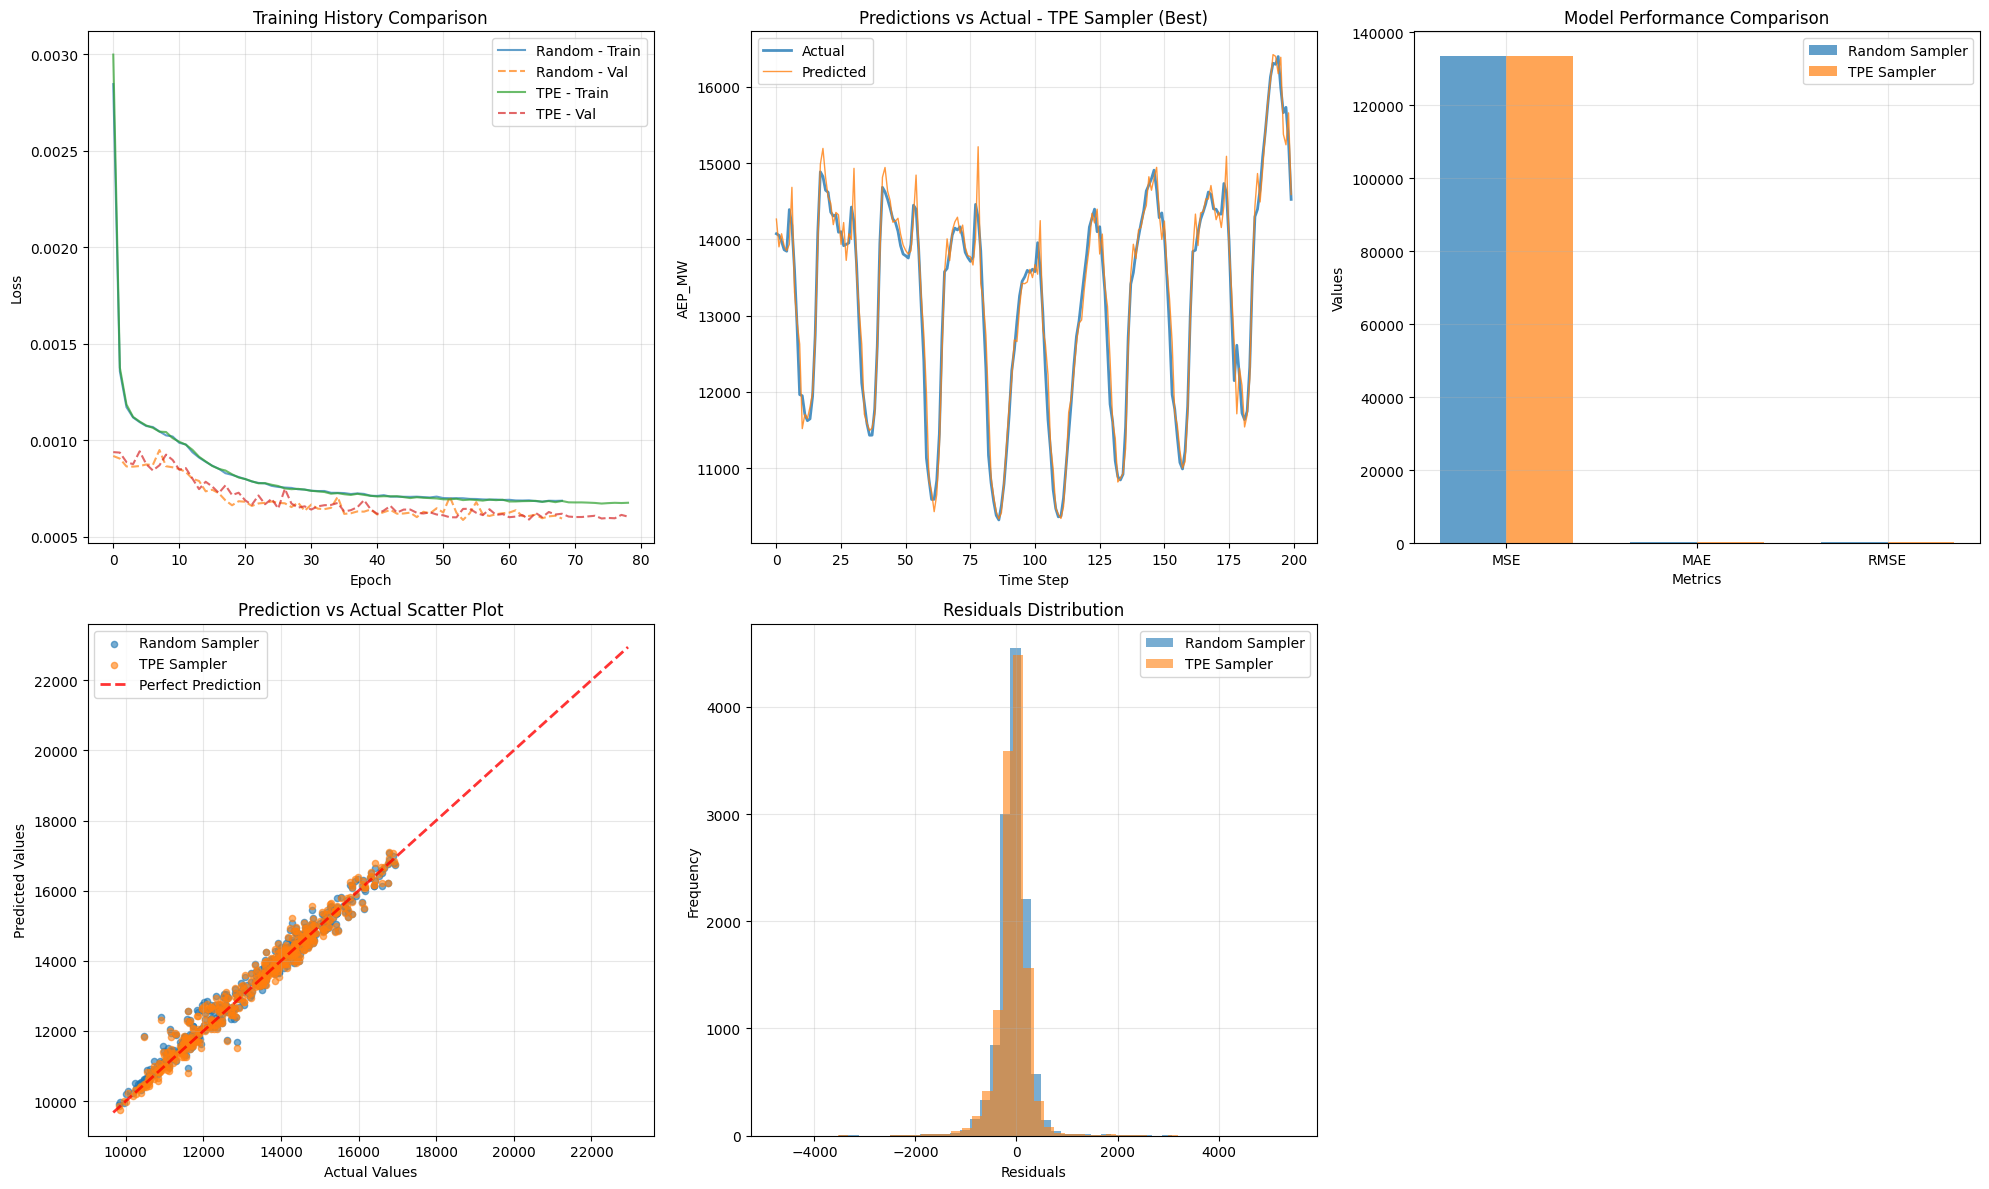

FINAL SUMMARY:
Best performing sampler: TPE
Best MSE: 133486.88
Best MAE: 212.38
Best RMSE: 365.36


In [42]:
# Plot comprehensive results
plt.figure(figsize=(20, 12))

# Plot 1: Training and validation loss for both models
plt.subplot(2, 3, 1)
for sampler_name in final_results.keys():
    history = final_results[sampler_name]['history'].history
    plt.plot(history['loss'], label=f'{sampler_name} - Train', alpha=0.7)
    plt.plot(history['val_loss'], label=f'{sampler_name} - Val', linestyle='--', alpha=0.7)
plt.title('Training History Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual for best model
best_sampler = min(final_results, key=lambda x: final_results[x]['mse'])
plt.subplot(2, 3, 2)
plt.plot(final_results[best_sampler]['actual'][:200],
         label='Actual', alpha=0.8, linewidth=2)
plt.plot(final_results[best_sampler]['predictions'][:200],
         label='Predicted', alpha=0.8, linewidth=1)
plt.title(f'Predictions vs Actual - {best_sampler} Sampler (Best)')
plt.xlabel('Time Step')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Metric comparison bar plot
plt.subplot(2, 3, 3)
metrics = ['MSE', 'MAE', 'RMSE']
x_pos = np.arange(len(metrics))
width = 0.35

for i, sampler in enumerate(final_results.keys()):
    values = [
        final_results[sampler]['mse'],
        final_results[sampler]['mae'],
        final_results[sampler]['rmse']
    ]
    plt.bar(x_pos + i*width, values, width, label=f'{sampler} Sampler', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Comparison')
plt.xticks(x_pos + width/2, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Scatter plot of predictions vs actual
plt.subplot(2, 3, 4)
for sampler in final_results.keys():
    plt.scatter(
        final_results[sampler]['actual'][:500],
        final_results[sampler]['predictions'][:500],
        alpha=0.6,
        label=f'{sampler} Sampler',
        s=20
    )
min_val = min(final_results[best_sampler]['actual'].min(),
              final_results[best_sampler]['predictions'].min())
max_val = max(final_results[best_sampler]['actual'].max(),
              final_results[best_sampler]['predictions'].max())
plt.plot([min_val, max_val], [min_val, max_val],
         'r--', alpha=0.8, label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Scatter Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Residuals plot
plt.subplot(2, 3, 5)
for sampler in final_results.keys():
    residuals = final_results[sampler]['actual'] - final_results[sampler]['predictions']
    plt.hist(residuals, bins=50, alpha=0.6, label=f'{sampler} Sampler')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("FINAL SUMMARY:")
best_overall = min(final_results, key=lambda x: final_results[x]['mse'])
print(f"Best performing sampler: {best_overall}")
print(f"Best MSE: {final_results[best_overall]['mse']:.2f}")
print(f"Best MAE: {final_results[best_overall]['mae']:.2f}")
print(f"Best RMSE: {final_results[best_overall]['rmse']:.2f}")

##14. Final Discussion

After overall optimization of the GRU models for AEP_MW energy forecasting, the TPE sampler performed slightly better than the Random sampler, with an MSE of 133,486.88, MAE of 212.38, and RMSE of 365.36. The differences were minimal, though, with the most dramatic improvement seeing a 1.8% reduction in MAE, and the TPE method consistently produced higher results in all of the metrics of assessment. Both models demonstrated excellent training performance with converging stable and early convergence at epochs 54-79, indicating proper learning without overfitting on the huge database of 121,273 hourly records spanning 2004-2018.

The resulting performance metrics are very precise forecasting results for energy load forecasting, with the MAE of some 212 MW registering only 1.37% deviation from the dataset mean of 15,499.51 MW. This level of accuracy is particularly impressive given the variability of the time series data, having a standard deviation of 2,591 MW and multiple overlapping seasonal effects. The models were successful at identifying the underlying temporal patterns despite these challenges, demonstrating the capability of GRU architectures for energy consumption forecasting.

For production deployment, the TPE-optimized model is recommended due to its consistent performance improvements, even though the Random sampler may still be employed in those rapid-prototyping contexts with limited computation time. That the minimum gap in performance suggests that either optimization method for hyperparameters may be employed in order to create production-level models, but the superiority of the TPE sampler in finding marginally better settings as the optimal reason, makes it the best option for final implementation.

Summarily, the GRU models optimized through this process of obtaining accurate and reliable forecasting capability for AEP_MW energy consumption are successful in extracting complex temporal patterns from the 14-year dataset, with the optimal performance of the TPE-optimized model serving for deployment application. Monitoring and re-training on a regular basis will ensure the maintenance of performance level over time, with future enhancements potentially involving additional features such as weather and holiday indicators to further improve predictive efficiency.